In [204]:
import json
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv
from tqdm import tqdm
import matplotlib.pyplot as plt


In [205]:
json_file = 'elyzee_data/elyzee_train.json'
graph_train_networkx = nx.node_link_graph(json.load(open(json_file)))

json_file = 'elyzee_data/elyzee_test.json'
graph_test_networkx = nx.node_link_graph(json.load(open(json_file)))

In [206]:
num_classes = 7
labels_dict = {
    'lr': 0, 
    'em': 1, 
    'fn': 2, 
    'fi': 3, 
    'ps': 4,
    'multi_affiliations': 5, 
    'indetermined': 6
}
node_id = list(graph_train_networkx.nodes)[0]
num_features = len(graph_train_networkx.nodes[node_id]['features'])

In [207]:
graph_train_torch = from_networkx(graph_train_networkx)
graph_test_torch = from_networkx(graph_test_networkx)
print("Train :",graph_train_torch)
print("Test :",graph_test_torch)

Train : Data(edge_index=[2, 19284], features=[5507, 999], affiliation=[5507], num_nodes=5507)
Test : Data(edge_index=[2, 6402], features=[2222, 999], affiliation=[2222], num_nodes=2222)


In [208]:
graph_train_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_train_torch.affiliation]
)).float()
graph_test_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_test_torch.affiliation]
)).float()
print("Train labels :", graph_train_torch.labels.shape)
print("Test labels :", graph_test_torch.labels.shape)


Train labels : torch.Size([5507, 7])
Test labels : torch.Size([2222, 7])


# Experience 1 : FCNN

In [261]:
class FCNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(num_features, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.linear2(x)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.linear3(x)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [262]:
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.01
    decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_test = []
    list_train_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features)
        # Compute loss
        loss_train = criterion(logits_train, graph_train.labels) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train, dim=1) == torch.argmax(graph_train.labels, dim=1)).float().mean()
        list_train_acc.append(train_acc)
        
        
        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                logits_test = model(graph_test.features)
                loss_test = criterion(logits_test, graph_test.labels)
                list_loss_test.append(loss_test.item())
                test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
                list_test_acc.append(test_acc)
                print('Epoch %d | Loss Train : %.4f | Train Accuracy : %.4f | Loss Test: %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), train_acc, loss_test.item(), test_acc))
                
    return list_loss_train, list_loss_test, list_train_acc, list_test_acc

Epoch 0 | Loss Train : 1.9448 | Train Accuracy : 0.1874 | Loss Test: 1.9423 | Test Accuracy: 0.1890
Epoch 1 | Loss Train : 1.9401 | Train Accuracy : 0.2085 | Loss Test: 1.9361 | Test Accuracy: 0.1890
Epoch 2 | Loss Train : 1.9307 | Train Accuracy : 0.2105 | Loss Test: 1.9307 | Test Accuracy: 0.1890
Epoch 3 | Loss Train : 1.9152 | Train Accuracy : 0.2103 | Loss Test: 1.9235 | Test Accuracy: 0.1890
Epoch 4 | Loss Train : 1.9025 | Train Accuracy : 0.2103 | Loss Test: 1.9273 | Test Accuracy: 0.1890
Epoch 5 | Loss Train : 1.9049 | Train Accuracy : 0.2103 | Loss Test: 1.9303 | Test Accuracy: 0.1890
Epoch 6 | Loss Train : 1.9047 | Train Accuracy : 0.2103 | Loss Test: 1.9279 | Test Accuracy: 0.1890
Epoch 7 | Loss Train : 1.9005 | Train Accuracy : 0.2103 | Loss Test: 1.9234 | Test Accuracy: 0.1890
Epoch 8 | Loss Train : 1.8939 | Train Accuracy : 0.2103 | Loss Test: 1.9200 | Test Accuracy: 0.1890
Epoch 9 | Loss Train : 1.8884 | Train Accuracy : 0.2103 | Loss Test: 1.9190 | Test Accuracy: 0.1890


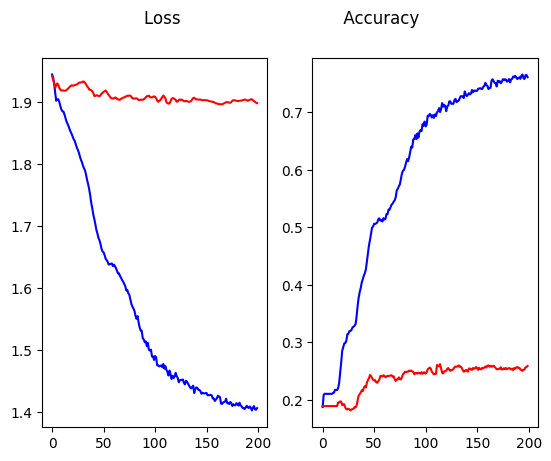

In [263]:
model_fcnn = FCNN(num_features=num_features, hidden_channels=64, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_fcnn.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_fcnn,
    graph_train_torch,
    graph_test_torch,
    200
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

# Experience 2 : GCN

In [287]:
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.001
    decay = 1e-5
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_test = []
    list_train_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features, graph_train.edge_index)
        # Compute loss
        loss_train = criterion(logits_train, graph_train.labels) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train, dim=1) == torch.argmax(graph_train.labels, dim=1)).float().mean()
        list_train_acc.append(train_acc)
        
        
        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                logits_test = model(graph_test.features, graph_test.edge_index)
                loss_test = criterion(logits_test, graph_test.labels)
                list_loss_test.append(loss_test.item())
                test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
                list_test_acc.append(test_acc)
                print('Epoch %d | Loss Train : %.4f | Train Accuracy : %.4f | Loss Test: %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), train_acc, loss_test.item(), test_acc))
                
    return list_loss_train, list_loss_test, list_train_acc, list_test_acc

In [288]:
class GCN_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_1, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

Epoch 0 | Loss Train : 1.9481 | Train Accuracy : 0.0995 | Loss Test: 1.9440 | Test Accuracy: 0.1350
Epoch 1 | Loss Train : 1.9389 | Train Accuracy : 0.1736 | Loss Test: 1.9412 | Test Accuracy: 0.2142
Epoch 2 | Loss Train : 1.9293 | Train Accuracy : 0.2998 | Loss Test: 1.9381 | Test Accuracy: 0.2822
Epoch 3 | Loss Train : 1.9191 | Train Accuracy : 0.3614 | Loss Test: 1.9348 | Test Accuracy: 0.3177
Epoch 4 | Loss Train : 1.9085 | Train Accuracy : 0.3873 | Loss Test: 1.9314 | Test Accuracy: 0.3177
Epoch 5 | Loss Train : 1.8989 | Train Accuracy : 0.3875 | Loss Test: 1.9279 | Test Accuracy: 0.3191
Epoch 6 | Loss Train : 1.8880 | Train Accuracy : 0.3944 | Loss Test: 1.9241 | Test Accuracy: 0.3371
Epoch 7 | Loss Train : 1.8775 | Train Accuracy : 0.3855 | Loss Test: 1.9201 | Test Accuracy: 0.3501
Epoch 8 | Loss Train : 1.8654 | Train Accuracy : 0.3835 | Loss Test: 1.9158 | Test Accuracy: 0.3533
Epoch 9 | Loss Train : 1.8529 | Train Accuracy : 0.3806 | Loss Test: 1.9114 | Test Accuracy: 0.3528


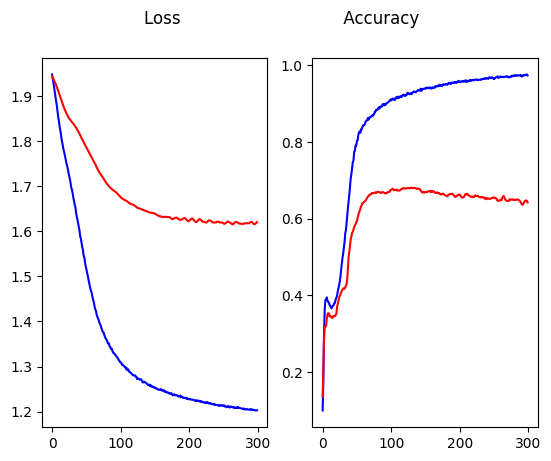

In [289]:
model_gcn1 = GCN_1(hidden_channels=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn1 = model_gcn1.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_gcn1,
    graph_train_torch,
    graph_test_torch,
    300
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

In [290]:
class GCN_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_2, self).__init__()

        # Initialize the layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

Epoch 0 | Loss Train : 1.9462 | Train Accuracy : 0.1117 | Loss Test: 1.9449 | Test Accuracy: 0.1539
Epoch 1 | Loss Train : 1.9444 | Train Accuracy : 0.2061 | Loss Test: 1.9441 | Test Accuracy: 0.1571
Epoch 2 | Loss Train : 1.9402 | Train Accuracy : 0.2332 | Loss Test: 1.9431 | Test Accuracy: 0.1868
Epoch 3 | Loss Train : 1.9377 | Train Accuracy : 0.2252 | Loss Test: 1.9417 | Test Accuracy: 0.2552
Epoch 4 | Loss Train : 1.9334 | Train Accuracy : 0.2695 | Loss Test: 1.9397 | Test Accuracy: 0.2732
Epoch 5 | Loss Train : 1.9288 | Train Accuracy : 0.2595 | Loss Test: 1.9373 | Test Accuracy: 0.2448
Epoch 6 | Loss Train : 1.9225 | Train Accuracy : 0.2573 | Loss Test: 1.9343 | Test Accuracy: 0.2340
Epoch 7 | Loss Train : 1.9137 | Train Accuracy : 0.2562 | Loss Test: 1.9309 | Test Accuracy: 0.2304
Epoch 8 | Loss Train : 1.9099 | Train Accuracy : 0.2480 | Loss Test: 1.9269 | Test Accuracy: 0.1985
Epoch 9 | Loss Train : 1.8979 | Train Accuracy : 0.2259 | Loss Test: 1.9226 | Test Accuracy: 0.1962


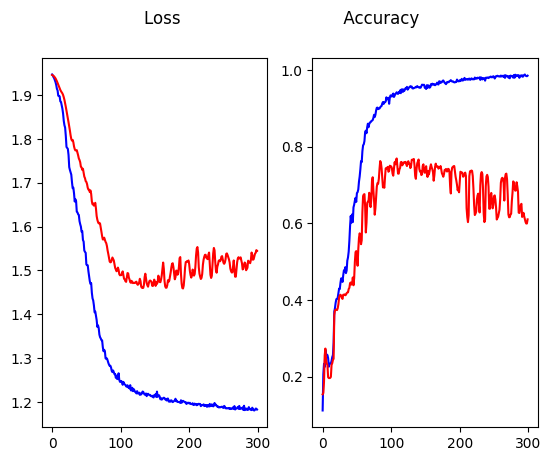

In [295]:
model_gcn2 = GCN_2(hidden_channels=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn2 = model_gcn2.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_gcn2,
    graph_train_torch,
    graph_test_torch,
    300
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

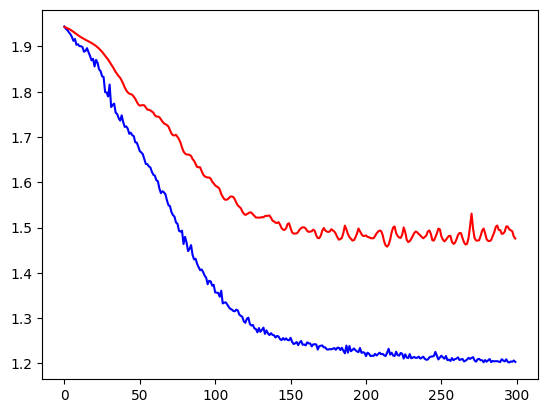

In [292]:

plt.plot(list_loss_train, color='blue')
plt.plot(list_loss_test, color='red')

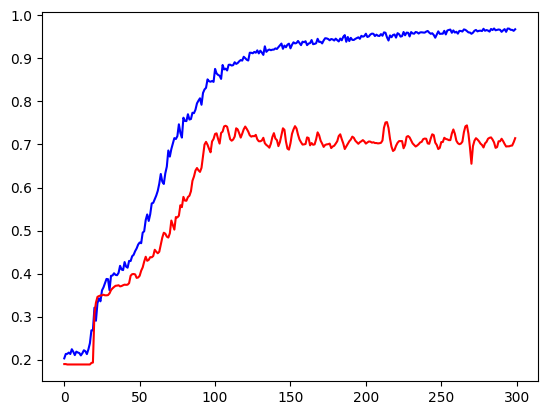

In [293]:
plt.plot(list_train_acc, color='blue')
plt.plot(list_test_acc, color='red')